In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

In [2]:
path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


--------
# Librosa study

In [3]:
y, sr = librosa.load(audio_path+'/0.wav', sr=None) # try to resample and see if it works better
# y, sr = librosa.load(audio_path+'/0.wav') # resample to 22050
sr

8000

In [4]:
duration = y.shape[0]/sr
duration

2.169

In [5]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfccs.shape 
# shape[1] changes due to time.
# Hence we need something that will be coherent between different audio files

(13, 34)

In [6]:
mfccs.mean(axis=1)
mfccs.std(axis=1)

array([121.12228  ,  14.878011 ,  43.41631  ,  10.420819 ,  19.91728  ,
        12.009927 ,   7.8241935,   7.469521 ,  10.892664 ,  11.176961 ,
         6.5190754,   6.111745 ,   5.827874 ], dtype=float32)

In [7]:
delta_mfcc = librosa.feature.delta(mfccs, order=1)
delta2_mfcc = librosa.feature.delta(mfccs, order=2)
delta_mfcc.shape

(13, 34)

In [8]:
np.mean(delta_mfcc, axis=- 1).shape

(13,)

In [9]:
zcr = librosa.feature.zero_crossing_rate(y)
zcr.shape

(1, 34)

In [10]:
zcr.mean(axis=1)
zcr.std(axis=1)

array([0.04388731])

---------------

# use mean and std of mfccs, delta, delta2 (mean along time axis) and zcr + duration

In [28]:
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    y, sr = librosa.load(audio_path+filename, sr=None)
    d1['duration'] = y.shape[0]/sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    d1['mfccs_mean'] = mfccs.mean(axis=-1)
    d1['mfccs_std'] = mfccs.std(axis=-1)
    d1['delta_mfcc_mean'] = librosa.feature.delta(mfccs, order=1).mean(axis=-1)
    d1['delta_mfcc_std'] = librosa.feature.delta(mfccs, order=1).std(axis=-1)
    d1['delta2_mfcc_mean'] = librosa.feature.delta(mfccs, order=2).mean(axis=-1)
    d1['delta2_mfcc_std'] = librosa.feature.delta(mfccs, order=2).std(axis=-1)
    d1['zcr_mean'] = librosa.feature.zero_crossing_rate(y).mean(axis=-1)[0]
    d1['zcr_std'] = librosa.feature.zero_crossing_rate(y).std(axis=-1)[0]
    d[(int)(filename.split('.')[0])] = d1

temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9597/9597 [01:51<00:00, 85.75it/s] 


,duration,mfccs_mean,mfccs_std,delta_mfcc_mean,delta_mfcc_std,delta2_mfcc_mean,delta2_mfcc_std,zcr_mean,zcr_std,encoded_emotion
0,2.169000,"[-317.81097, 130.70448, -12.395517, 30.511158,...","[121.12228, 14.878011, 43.41631, 10.420819, 19...","[-0.8474461, 0.09749135, 0.33125877, -0.014412...","[27.83217, 2.1818287, 11.493292, 2.925932, 3.6...","[2.4709852, -0.6889033, -0.926084, -0.13175406...","[13.471112, 2.5428102, 5.78616, 1.4316927, 1.4...",0.101017,0.043887,0
1,2.669500,"[-396.10388, 144.79655, 18.632975, 41.45097, -...","[56.79848, 17.845198, 25.344776, 11.786258, 14...","[0.15239239, -0.14539853, 0.1898662, -0.042617...","[9.222635, 3.3245676, 5.5552764, 2.3359957, 3....","[0.024261782, -0.22617248, 0.15344347, -0.0939...","[4.472004, 1.7439122, 3.423194, 1.8626183, 2.1...",0.067057,0.0188,1
2,3.837375,"[-556.75964, 61.434036, -2.0914085, 13.791684,...","[204.68938, 48.95614, 32.23909, 19.827524, 20....","[0.05304133, 0.07402297, 0.07117597, 0.0667230...","[29.193336, 6.9536414, 6.429919, 4.2542844, 3....","[0.012825201, 0.017571567, 0.01579771, 0.01324...","[14.257467, 3.3208814, 5.055201, 2.933674, 2.2...",0.081445,0.052005,2
3,3.403625,"[-570.33844, 53.714615, -5.7283487, 19.4942, -...","[229.19054, 38.00371, 32.08954, 20.652245, 27....","[-0.40987745, -0.12593555, 0.17347701, -0.0015...","[30.91453, 5.997112, 5.7959046, 4.2375636, 4.5...","[0.023708176, 0.0153127685, -0.0082633905, -0....","[12.5489645, 2.93022, 3.838187, 3.4667785, 2.7...",0.094916,0.048519,3
4,2.869750,"[-167.22997, 97.66535, -14.925374, 16.654722, ...","[180.73991, 27.160816, 53.352364, 30.935242, 3...","[-0.4098132, -0.3095212, 0.13756083, 0.3111525...","[34.375626, 3.8496368, 11.931849, 7.0022345, 6...","[2.5584428, -0.2507055, -1.1245984, -0.2396748...","[16.160292, 2.720585, 6.601379, 3.5213737, 2.7...",0.123644,0.052133,4


In [72]:
temp_df.columns

Index(['duration', 'mfccs_mean', 'mfccs_std', 'delta_mfcc_mean',
       'delta_mfcc_std', 'delta2_mfcc_mean', 'delta2_mfcc_std', 'zcr_mean',
       'zcr_std', 'encoded_emotion'],
      dtype='object')

In [79]:
temp_df.columns
col = ['mfccs_mean', 'mfccs_std', 'delta_mfcc_mean', 'delta_mfcc_std', 'delta2_mfcc_mean', 'delta2_mfcc_std']
peffo = dict()
sisghe = dict()
for row in temp_df.index:
    sisghe[row] = {f'{c}_{k}':v for k,v in enumerate(temp_df[c].loc[row]) for c in col}

feature_df = pd.DataFrame.from_dict(sisghe).T
feature_df['duration'] = temp_df.duration
feature_df['zcr_mean'] = temp_df.zcr_mean
feature_df['zcr_std'] = temp_df.zcr_std
feature_df['encoded_emotion'] = temp_df.encoded_emotion

feature_df.head()

,mfccs_mean_0,mfccs_std_0,delta_mfcc_mean_0,delta_mfcc_std_0,delta2_mfcc_mean_0,delta2_mfcc_std_0,mfccs_mean_1,mfccs_std_1,delta_mfcc_mean_1,delta_mfcc_std_1,...,mfccs_mean_12,mfccs_std_12,delta_mfcc_mean_12,delta_mfcc_std_12,delta2_mfcc_mean_12,delta2_mfcc_std_12,duration,zcr_mean,zcr_std,encoded_emotion
0,13.471112,13.471112,13.471112,13.471112,13.471112,13.471112,2.542810,2.542810,2.542810,2.542810,...,0.861669,0.861669,0.861669,0.861669,0.861669,0.861669,2.169000,0.101017,0.043887,0
1,4.472004,4.472004,4.472004,4.472004,4.472004,4.472004,1.743912,1.743912,1.743912,1.743912,...,0.782062,0.782062,0.782062,0.782062,0.782062,0.782062,2.669500,0.067057,0.0188,1
2,14.257467,14.257467,14.257467,14.257467,14.257467,14.257467,3.320881,3.320881,3.320881,3.320881,...,0.970723,0.970723,0.970723,0.970723,0.970723,0.970723,3.837375,0.081445,0.052005,2
3,12.548965,12.548965,12.548965,12.548965,12.548965,12.548965,2.930220,2.930220,2.930220,2.930220,...,0.902798,0.902798,0.902798,0.902798,0.902798,0.902798,3.403625,0.094916,0.048519,3
4,16.160292,16.160292,16.160292,16.160292,16.160292,16.160292,2.720585,2.720585,2.720585,2.720585,...,0.930767,0.930767,0.930767,0.930767,0.930767,0.930767,2.869750,0.123644,0.052133,4


In [77]:
tot_length = temp_df.mfccs_mean.loc[0].size + temp_df.mfccs_std.loc[0].size + temp_df.delta_mfcc_mean.loc[0].size + temp_df.delta_mfcc_std.loc[0].size + temp_df.delta2_mfcc_mean.loc[0].size + temp_df.delta2_mfcc_std.loc[0].size
tot_length + 4 # checked

82

In [13]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible


In [88]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC 

np.random.seed(0) #to make experiments reproducible

smote = SMOTE(random_state=42)
blsmote = BorderlineSMOTE(random_state=42)
svmsmote = SVMSMOTE(random_state=42)
adasyn = ADASYN(random_state=42, sampling_strategy='minority')


#print(ksmote.cluster_balance_threshold)
#over_samplers = [smote, blsmote, svmsmote, adasyn, ksmote]
over_samplers = [smote, blsmote, svmsmote, adasyn]

for sm in tqdm(over_samplers):
    print(sm)
    X, y = feature_df[feature_df.columns[:-1]], feature_df[feature_df.columns[-1]]
    X_res, y_res = sm.fit_resample(X,y)

    minmax = MinMaxScaler()
    svm_X_res = minmax.fit_transform(X_res)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)
    svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    
    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting RF...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting using RF...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    print(rf, score)
    
    print('Fitting SVC...')
    svm = SVC().fit(svm_X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(svm_X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    print(svm, svm_score)

  0%|          | 0/4 [00:00<?, ?it/s]

SMOTE(random_state=42)
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.583017016084837
Fitting SVC...
Predicting using SVC...


 25%|██▌       | 1/4 [00:14<00:43, 14.43s/it]

SVC() 0.5270888576207117
BorderlineSMOTE(random_state=42)
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.5743402634472566
Fitting SVC...
Predicting using SVC...


 50%|█████     | 2/4 [00:29<00:30, 15.00s/it]

SVC() 0.5245943022498454
SVMSMOTE(random_state=42)
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.5774962454606364
Fitting SVC...
Predicting using SVC...


 75%|███████▌  | 3/4 [01:14<00:28, 28.60s/it]

SVC() 0.5240967349162368
ADASYN(random_state=42, sampling_strategy='minority')
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.5553939143279746
Fitting SVC...
Predicting using SVC...


100%|██████████| 4/4 [01:27<00:00, 21.89s/it]

SVC() 0.5250355019976605


--------------------
# use mfccs as spectrograms and divide in blocks. Then mean and std

In [90]:
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    y, sr = librosa.load(audio_path+filename, sr=None)
    d1['duration'] = y.shape[0]/sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    d1['mfccs'] = mfccs
    d1['delta_mfcc'] = librosa.feature.delta(mfccs, order=1)
    d1['delta2_mfcc'] = librosa.feature.delta(mfccs, order=2)
    d1['zcr'] = librosa.feature.zero_crossing_rate(y)    
    d[(int)(filename.split('.')[0])] = d1

temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9597/9597 [01:41<00:00, 94.74it/s] 


,duration,mfccs,delta_mfcc,delta2_mfcc,zcr,encoded_emotion
0,2.169000,"[[-493.01044, -460.0894, -458.284, -457.54904,...","[[20.930767, 20.930767, 20.930767, 20.930767, ...","[[11.189412, 11.189412, 11.189412, 11.189412, ...","[[0.02392578125, 0.0380859375, 0.05126953125, ...",0
1,2.669500,"[[-463.8445, -448.02594, -447.8502, -450.42685...","[[3.9649913, 3.9649913, 3.9649913, 3.9649913, ...","[[2.1696234, 2.1696234, 2.1696234, 2.1696234, ...","[[0.02734375, 0.041015625, 0.05126953125, 0.05...",1
2,3.837375,"[[-766.99445, -767.2107, -767.1353, -765.2035,...","[[0.9491689, 0.9491689, 0.9491689, 0.9491689, ...","[[0.090565205, 0.090565205, 0.090565205, 0.090...","[[0.0107421875, 0.0234375, 0.029296875, 0.0263...",2
3,3.403625,"[[-798.0724, -794.187, -791.83185, -790.31226,...","[[0.39514363, 0.39514363, 0.39514363, 0.395143...","[[-0.49802417, -0.49802417, -0.49802417, -0.49...","[[0.0146484375, 0.02978515625, 0.0537109375, 0...",3
4,2.869750,"[[-435.62903, -414.33167, -411.86377, -410.227...","[[21.180897, 21.180897, 21.180897, 21.180897, ...","[[14.337309, 14.337309, 14.337309, 14.337309, ...","[[0.02880859375, 0.04443359375, 0.0595703125, ...",4


In [92]:
print(temp_df.mfccs.map(lambda x: x.shape)[0])
print(temp_df.delta_mfcc.map(lambda x: x.shape)[0])
print(temp_df.delta2_mfcc.map(lambda x: x.shape)[0])

(13, 34)
(13, 34)
(13, 34)


In [103]:
def divide_matrix(ary:np.array, num_columns:int, num_rows:int):    
    
    if (num_columns > ary.shape[1] or num_rows > ary.shape[0]):
        return 'Error, the requested number of columns or rows exceed dimensions!'
    
    first = np.array_split(ary, num_rows, axis=0) # num rows
    second = []
    for array in first:
        second.append(np.array_split(array, num_columns, axis=1)) # num columns
    flattened_list = flatten(second)
    return flattened_list

def flatten(l:list):
    flattened_list = []
    for item in l:
        for i in item:
            flattened_list.append(i)
    return flattened_list
    
def compute_feature(list_of_arrays:list, prefix=None) -> dict:
    
    d = dict()
    
    if prefix == None:
      for id in range(len(list_of_arrays)):
          d[f'{id}_mean_feature'] = np.mean(list_of_arrays[id])
          d[f'{id}_std_feature'] = np.std(list_of_arrays[id])
    else:
      for id in range(len(list_of_arrays)):
          d[f'{id}_{prefix}_mean_feature'] = np.mean(list_of_arrays[id])
          d[f'{id}_{prefix}_std_feature'] = np.std(list_of_arrays[id])

    return d



### MFCC non concatenati


In [127]:
features = ['mfccs', 'delta_mfcc', 'delta2_mfcc']

n = 5

prova = dict()
for row in tqdm(temp_df.index):
    for f in features:
        prova[row] = compute_feature(divide_matrix(temp_df[f].loc[row], num_rows=min(n, 13), num_columns=n), prefix=f)
    

n_df = pd.DataFrame.from_dict(prova).T
n_df['duration'] = temp_df.duration
n_df['min_zcr'] = temp_df.zcr.map(lambda x: min(flatten(list(x))))
n_df['max_zcr'] = temp_df.zcr.map(lambda x: max(flatten(list(x))))
n_df['encoded_emotion'] = temp_df.encoded_emotion
n_df.head()

100%|██████████| 9597/9597 [00:39<00:00, 241.42it/s]


,0_delta2_mfcc_mean_feature,0_delta2_mfcc_std_feature,1_delta2_mfcc_mean_feature,1_delta2_mfcc_std_feature,2_delta2_mfcc_mean_feature,2_delta2_mfcc_std_feature,3_delta2_mfcc_mean_feature,3_delta2_mfcc_std_feature,4_delta2_mfcc_mean_feature,4_delta2_mfcc_std_feature,...,22_delta2_mfcc_mean_feature,22_delta2_mfcc_std_feature,23_delta2_mfcc_mean_feature,23_delta2_mfcc_std_feature,24_delta2_mfcc_mean_feature,24_delta2_mfcc_std_feature,duration,min_zcr,max_zcr,encoded_emotion
0,1.584157,7.133420,-1.294042,6.790268,0.305728,5.258142,-1.470796,11.668770,2.637663,10.655533,...,-0.492043,1.287269,0.512299,0.796199,-0.914486,0.114833,2.169000,0.023926,0.195312,0
1,0.664240,2.204984,-0.127156,4.379223,-0.377394,4.562441,-0.290630,3.393468,-0.021013,0.917018,...,-0.254022,0.933518,0.033549,0.750465,0.412188,0.142056,2.669500,0.027344,0.115234,1
2,0.262094,2.387905,-0.308649,10.726755,1.153995,11.086215,-2.696641,11.165792,1.666192,4.458411,...,-0.030803,1.396652,0.248478,0.851043,-0.181103,0.246956,3.837375,0.010742,0.175781,2
3,-0.174931,0.656531,0.224878,12.137231,-0.383463,5.391173,-0.052197,10.617236,0.479648,2.541689,...,0.110127,1.485579,0.102121,0.657516,-0.104862,0.550486,3.403625,0.014648,0.176758,3
4,2.565381,11.134707,-2.416049,10.358296,0.408938,4.787992,-2.054565,11.424722,3.468194,10.944690,...,0.043695,1.612709,0.212995,1.241706,-0.412430,0.579305,2.869750,0.028809,0.210938,4


concatenate mfccs and deltas

In [133]:
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    y, sr = librosa.load(audio_path+filename, sr=None)
    d1['duration'] = y.shape[0]/sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfccs, order=1)
    delta2_mfcc = librosa.feature.delta(mfccs, order=2)
    d1['mfccs'] = np.concatenate([mfccs, delta_mfcc, delta2_mfcc])
    
    d1['zcr'] = librosa.feature.zero_crossing_rate(y)    
    d[(int)(filename.split('.')[0])] = d1

temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9597/9597 [01:45<00:00, 91.06it/s] 


,duration,mfccs,zcr,encoded_emotion
0,2.169000,"[[-493.01044, -460.0894, -458.284, -457.54904,...","[[0.02392578125, 0.0380859375, 0.05126953125, ...",0
1,2.669500,"[[-463.8445, -448.02594, -447.8502, -450.42685...","[[0.02734375, 0.041015625, 0.05126953125, 0.05...",1
2,3.837375,"[[-766.99445, -767.2107, -767.1353, -765.2035,...","[[0.0107421875, 0.0234375, 0.029296875, 0.0263...",2
3,3.403625,"[[-798.0724, -794.187, -791.83185, -790.31226,...","[[0.0146484375, 0.02978515625, 0.0537109375, 0...",3
4,2.869750,"[[-435.62903, -414.33167, -411.86377, -410.227...","[[0.02880859375, 0.04443359375, 0.0595703125, ...",4


  0%|          | 0/7 [00:00<?, ?it/s]

1
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6897385405632084
Fitting SVC...
Predicting using SVC...


 14%|█▍        | 1/7 [00:28<02:51, 28.50s/it]

SVC() 0.6540802763363625
2
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7075009851022404
Fitting SVC...
Predicting using SVC...


 29%|██▊       | 2/7 [01:14<03:12, 38.52s/it]

SVC() 0.6919189226013225
3
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6905144502925519
Fitting SVC...
Predicting using SVC...


 43%|████▎     | 3/7 [02:18<03:22, 50.55s/it]

SVC() 0.6838447398586797
4
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7013258819354036
Fitting SVC...
Predicting using SVC...


 57%|█████▋    | 4/7 [03:43<03:11, 63.88s/it]

SVC() 0.6662674557980139
5
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6905975870037391
Fitting SVC...
Predicting using SVC...


 71%|███████▏  | 5/7 [05:25<02:35, 77.75s/it]

SVC() 0.674800230202633
6
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6926575549499345
Fitting SVC...
Predicting using SVC...


 86%|████████▌ | 6/7 [07:35<01:35, 95.51s/it]

SVC() 0.6718178648096657
7
Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.6864763433340685
Fitting SVC...
Predicting using SVC...


100%|██████████| 7/7 [09:56<00:00, 85.18s/it] 

SVC() 0.6620651620079757


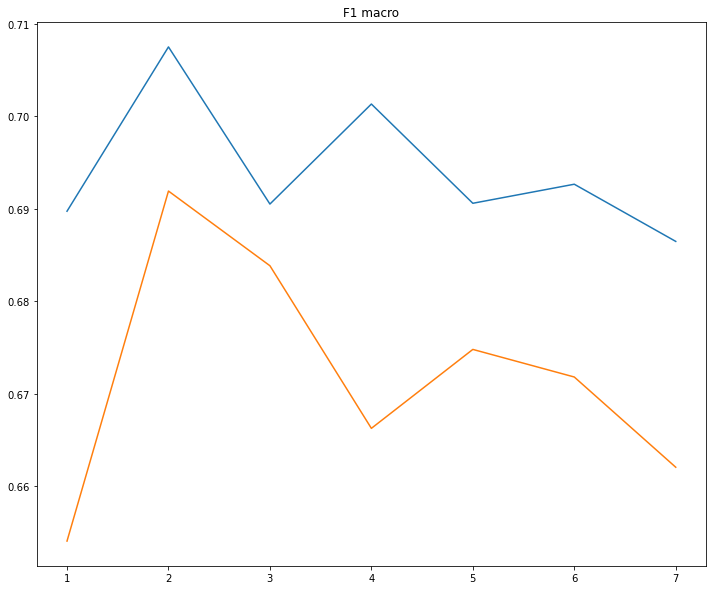

In [139]:


# ns = list(range(4,41,4))
ns = list(range(1,8))
scores_rf = []
scores_svm = []
for n in tqdm(ns):
    print(n)
    dictionary = dict()
    features = ['mfccs']

    prova = dict()
    for row in temp_df.index:
        for f in features:
            prova[row] = compute_feature(flatten(divide_matrix(temp_df[f].loc[row], num_rows=n, num_columns=n)), prefix=f)
        

    n_df = pd.DataFrame.from_dict(prova).T
    n_df['duration'] = temp_df.duration
    n_df['min_zcr'] = temp_df.zcr.map(lambda x: min(flatten(list(x))))
    n_df['max_zcr'] = temp_df.zcr.map(lambda x: max(flatten(list(x))))
    n_df['encoded_emotion'] = temp_df.encoded_emotion
    n_df.head()
    
    np.random.seed(0) #to make experiments reproducible


    smote = SMOTE(random_state=42)

    X, y = n_df[n_df.columns[:-1]], n_df[n_df.columns[-1]]
    X_res, y_res = smote.fit_resample(X,y)

    minmax = MinMaxScaler()
    svm_X_res = minmax.fit_transform(X_res)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)
    svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    print('Fitting RF...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting using RF...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores_rf.append(score)
    print(rf, score)

    print('Fitting SVC...')
    svm = SVC().fit(svm_X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(svm_X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    scores_svm.append(svm_score)
    print(svm, svm_score)
    
plt.figure(figsize=(12,10))
plt.title('F1 macro')
plt.plot(ns, scores_rf, label='RF')
plt.plot(ns, scores_svm, label='SVM')

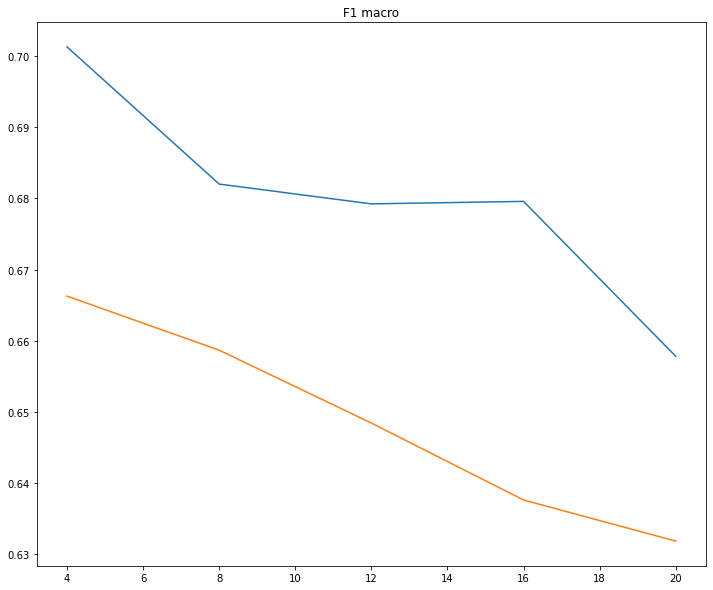

In [138]:
plt.figure(figsize=(12,10))
plt.title('F1 macro')
plt.plot(ns[:-1], scores_rf, label='RF')
plt.plot(ns[:-1], scores_svm, label='SVM')

In [141]:
idx = np.argmax(scores_rf)
scores_rf[idx]

0.7075009851022404

In [142]:
# grid search

n = 2

dictionary = dict()
features = ['mfccs']

prova = dict()
for row in temp_df.index:
    for f in features:
        prova[row] = compute_feature(flatten(divide_matrix(temp_df[f].loc[row], num_rows=n, num_columns=n)), prefix=f)
    

n_df = pd.DataFrame.from_dict(prova).T
n_df['duration'] = temp_df.duration
n_df['min_zcr'] = temp_df.zcr.map(lambda x: min(flatten(list(x))))
n_df['max_zcr'] = temp_df.zcr.map(lambda x: max(flatten(list(x))))
n_df['encoded_emotion'] = temp_df.encoded_emotion
n_df.head()

np.random.seed(0) #to make experiments reproducible


smote = SMOTE(random_state=42)

X, y = n_df[n_df.columns[:-1]], n_df[n_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('Fitting RF...')
rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
print('Predicting using RF...')
preds = rf.predict(X_test)
score = f1_score(y_test, preds, average='macro')
scores_rf.append(score)
print(rf, score)


Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7075009851022404


In [143]:
param_grid = {'n_estimators' : [100,150,300],
              'criterion': ['gini', 'entropy', 'log_loss'],
              #'max_depth': [10,20,30,None],
              'max_features': ['sqrt', 'log2', None]}

clfs = []
for configuration in tqdm(ParameterGrid(param_grid)):
    print('Fitting...')
    rf = RandomForestClassifier(**configuration).fit(X_train, y_train)
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    clfs.append((rf, score))
    print(rf, score)
    print('---------')

  0%|          | 0/27 [00:00<?, ?it/s]

Fitting...


  4%|▎         | 1/27 [00:07<03:21,  7.76s/it]

Predicting...
RandomForestClassifier() 0.7077048535071128
---------
Fitting...


  7%|▋         | 2/27 [00:19<04:12, 10.11s/it]

Predicting...
RandomForestClassifier(n_estimators=150) 0.7110177508829274
---------
Fitting...


 11%|█         | 3/27 [00:42<06:25, 16.08s/it]

Predicting...
RandomForestClassifier(n_estimators=300) 0.7069850975956192
---------
Fitting...


 15%|█▍        | 4/27 [00:47<04:27, 11.62s/it]

Predicting...
RandomForestClassifier(max_features='log2') 0.7086209491623029
---------
Fitting...


 19%|█▊        | 5/27 [00:54<03:39,  9.99s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=150) 0.708595416403315
---------
Fitting...


 22%|██▏       | 6/27 [01:08<03:58, 11.37s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=300) 0.7090672618656464
---------
Fitting...


 26%|██▌       | 7/27 [02:49<13:32, 40.62s/it]

Predicting...
RandomForestClassifier(max_features=None) 0.6928198680604115
---------
Fitting...


 30%|██▉       | 8/27 [05:22<24:12, 76.43s/it]

Predicting...
RandomForestClassifier(max_features=None, n_estimators=150) 0.6933813344659058
---------
Fitting...


 33%|███▎      | 9/27 [10:27<44:21, 147.88s/it]

Predicting...
RandomForestClassifier(max_features=None, n_estimators=300) 0.6976402715062194
---------
Fitting...


 37%|███▋      | 10/27 [10:41<30:10, 106.51s/it]

Predicting...
RandomForestClassifier(criterion='entropy') 0.7055245737615579
---------
Fitting...


 41%|████      | 11/27 [11:02<21:24, 80.25s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=150) 0.7046745641783707
---------
Fitting...


 44%|████▍     | 12/27 [11:43<17:06, 68.41s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=300) 0.7070394510475267
---------
Fitting...


 48%|████▊     | 13/27 [11:52<11:43, 50.27s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2') 0.7092651883149934
---------
Fitting...


 52%|█████▏    | 14/27 [12:04<08:26, 38.98s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150) 0.7077335604630317
---------
Fitting...


 56%|█████▌    | 15/27 [12:30<06:58, 34.87s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=300) 0.7121621367044788
---------
Fitting...


 59%|█████▉    | 16/27 [15:13<13:29, 73.57s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None) 0.6935611311245246
---------
Fitting...


 63%|██████▎   | 17/27 [19:19<20:53, 125.31s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=150) 0.6964345540168093
---------
Fitting...


 67%|██████▋   | 18/27 [27:28<35:10, 234.50s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=300) 0.700405777293273
---------
Fitting...


 70%|███████   | 19/27 [27:41<22:25, 168.19s/it]

Predicting...
RandomForestClassifier(criterion='log_loss') 0.6959487088538417
---------
Fitting...


 74%|███████▍  | 20/27 [28:02<14:26, 123.81s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', n_estimators=150) 0.7049558234420553
---------
Fitting...
Predicting...


 78%|███████▊  | 21/27 [28:51<10:08, 101.36s/it]

RandomForestClassifier(criterion='log_loss', n_estimators=300) 0.7114806774281558
---------
Fitting...


 81%|████████▏ | 22/27 [29:03<06:12, 74.60s/it] 

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2') 0.7033337724823128
---------
Fitting...


 85%|████████▌ | 23/27 [29:22<03:51, 57.83s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=150) 0.6988519603390095
---------
Fitting...
Predicting...


 89%|████████▉ | 24/27 [29:59<02:35, 51.84s/it]

RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=300) 0.7100248857764307
---------
Fitting...


 93%|█████████▎| 25/27 [34:08<03:41, 110.76s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None) 0.7041066178706185
---------
Fitting...


 96%|█████████▋| 26/27 [40:12<03:06, 186.89s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None,
                       n_estimators=150) 0.7033067257593781
---------
Fitting...
Predicting...


100%|██████████| 27/27 [52:27<00:00, 116.58s/it]

RandomForestClassifier(criterion='log_loss', max_features=None,
                       n_estimators=300) 0.7068016038273696
---------


In [145]:
np.argmax([clf[-1] for clf in clfs])

14

In [146]:
clfs[14]

(RandomForestClassifier(criterion='entropy', max_features='log2',
                        n_estimators=300),
 0.7121621367044788)

In [175]:
from sklearn.metrics import accuracy_score, recall_score
preds = clfs[14][0].predict(X_test)
a = accuracy_score(y_test, preds),
r = recall_score(y_test, preds, average='macro')
a, r, 2*(np.dot(a,r))/(a+r)

((0.7195604395604396,), 0.7194650457477163, array([0.71951274]))

In [176]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,5), random_state=42).fit(svm_X_train, svm_y_train)

preds = mlp.predict(svm_X_test)
score = f1_score(y_test, preds, average='macro')

print(mlp, score)

MLPClassifier(hidden_layer_sizes=(100, 5), random_state=42) 0.6664869226744735


/Users/lorenzo/opt/anaconda3/envs/data_science/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [168]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, weights='distance').fit(X_train, y_train)

preds = knn.predict(X_test)

score = f1_score(y_test, preds, average = 'macro')

print(knn, score)

KNeighborsClassifier(n_neighbors=1, weights='distance') 0.644797259748087


# prova one hot encoding

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

import utils

path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels
one_hot = utils.one_hot_encoder(labels.size)

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


In [221]:
# MEAN and STD no concatenation
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    y, sr = librosa.load(audio_path+filename, sr=None)
    d1['duration'] = y.shape[0]/sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    d1['mfccs_mean'] = mfccs.mean(axis=-1)
    d1['mfccs_std'] = mfccs.std(axis=-1)
    d1['delta_mfcc_mean'] = librosa.feature.delta(mfccs, order=1).mean(axis=-1)
    d1['delta_mfcc_std'] = librosa.feature.delta(mfccs, order=1).std(axis=-1)
    d1['delta2_mfcc_mean'] = librosa.feature.delta(mfccs, order=2).mean(axis=-1)
    d1['delta2_mfcc_std'] = librosa.feature.delta(mfccs, order=2).std(axis=-1)
    d1['zcr_mean'] = librosa.feature.zero_crossing_rate(y).mean(axis=-1)[0]
    d1['zcr_std'] = librosa.feature.zero_crossing_rate(y).std(axis=-1)[0]
    d[(int)(filename.split('.')[0])] = d1

temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()
    

100%|██████████| 9597/9597 [02:11<00:00, 73.11it/s]


,duration,mfccs_mean,mfccs_std,delta_mfcc_mean,delta_mfcc_std,delta2_mfcc_mean,delta2_mfcc_std,zcr_mean,zcr_std,encoded_emotion
0,2.169000,"[-317.81097, 130.70448, -12.395517, 30.511158,...","[121.12228, 14.878011, 43.41631, 10.420819, 19...","[-0.8474461, 0.09749135, 0.33125877, -0.014412...","[27.83217, 2.1818287, 11.493292, 2.925932, 3.6...","[2.4709852, -0.6889033, -0.926084, -0.13175406...","[13.471112, 2.5428102, 5.78616, 1.4316927, 1.4...",0.101017,0.043887,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,2.669500,"[-396.10388, 144.79655, 18.632975, 41.45097, -...","[56.79848, 17.845198, 25.344776, 11.786258, 14...","[0.15239239, -0.14539853, 0.1898662, -0.042617...","[9.222635, 3.3245676, 5.5552764, 2.3359957, 3....","[0.024261782, -0.22617248, 0.15344347, -0.0939...","[4.472004, 1.7439122, 3.423194, 1.8626183, 2.1...",0.067057,0.0188,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,3.837375,"[-556.75964, 61.434036, -2.0914085, 13.791684,...","[204.68938, 48.95614, 32.23909, 19.827524, 20....","[0.05304133, 0.07402297, 0.07117597, 0.0667230...","[29.193336, 6.9536414, 6.429919, 4.2542844, 3....","[0.012825201, 0.017571567, 0.01579771, 0.01324...","[14.257467, 3.3208814, 5.055201, 2.933674, 2.2...",0.081445,0.052005,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,3.403625,"[-570.33844, 53.714615, -5.7283487, 19.4942, -...","[229.19054, 38.00371, 32.08954, 20.652245, 27....","[-0.40987745, -0.12593555, 0.17347701, -0.0015...","[30.91453, 5.997112, 5.7959046, 4.2375636, 4.5...","[0.023708176, 0.0153127685, -0.0082633905, -0....","[12.5489645, 2.93022, 3.838187, 3.4667785, 2.7...",0.094916,0.048519,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,2.869750,"[-167.22997, 97.66535, -14.925374, 16.654722, ...","[180.73991, 27.160816, 53.352364, 30.935242, 3...","[-0.4098132, -0.3095212, 0.13756083, 0.3111525...","[34.375626, 3.8496368, 11.931849, 7.0022345, 6...","[2.5584428, -0.2507055, -1.1245984, -0.2396748...","[16.160292, 2.720585, 6.601379, 3.5213737, 2.7...",0.123644,0.052133,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


In [2]:
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    y, sr = librosa.load(audio_path+filename, sr=None)
    d1['duration'] = y.shape[0]/sr
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    d1['mfccs'] = mfccs
    d1['delta_mfcc'] = librosa.feature.delta(mfccs, order=1)
    d1['delta2_mfcc'] = librosa.feature.delta(mfccs, order=2)
    d1['zcr'] = librosa.feature.zero_crossing_rate(y)    
    d[(int)(filename.split('.')[0])] = d1

temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9597/9597 [01:31<00:00, 104.44it/s]


,duration,mfccs,delta_mfcc,delta2_mfcc,zcr,encoded_emotion
0,2.169000,"[[-493.01044, -460.0894, -458.284, -457.54904,...","[[20.930767, 20.930767, 20.930767, 20.930767, ...","[[11.189412, 11.189412, 11.189412, 11.189412, ...","[[0.02392578125, 0.0380859375, 0.05126953125, ...",0
1,2.669500,"[[-463.8445, -448.02594, -447.8502, -450.42685...","[[3.9649913, 3.9649913, 3.9649913, 3.9649913, ...","[[2.1696234, 2.1696234, 2.1696234, 2.1696234, ...","[[0.02734375, 0.041015625, 0.05126953125, 0.05...",1
2,3.837375,"[[-766.99445, -767.2107, -767.1353, -765.2035,...","[[0.9491689, 0.9491689, 0.9491689, 0.9491689, ...","[[0.090565205, 0.090565205, 0.090565205, 0.090...","[[0.0107421875, 0.0234375, 0.029296875, 0.0263...",2
3,3.403625,"[[-798.0724, -794.187, -791.83185, -790.31226,...","[[0.39514363, 0.39514363, 0.39514363, 0.395143...","[[-0.49802417, -0.49802417, -0.49802417, -0.49...","[[0.0146484375, 0.02978515625, 0.0537109375, 0...",3
4,2.869750,"[[-435.62903, -414.33167, -411.86377, -410.227...","[[21.180897, 21.180897, 21.180897, 21.180897, ...","[[14.337309, 14.337309, 14.337309, 14.337309, ...","[[0.02880859375, 0.04443359375, 0.0595703125, ...",4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# ns = list(range(4,41,4))
ns = list(range(2,9, 2))
scores_rf = []
scores_svm = []
scores_mlp = []
scores_knn = []
for n in tqdm(ns[:2]):
    print(n)
    dictionary = dict()
    features = ['mfccs']

    prova = dict()
    for row in temp_df.index:
        for f in features:
            prova[row] = utils.compute_feature(utils.flatten(utils.divide_matrix(temp_df[f].loc[row], num_rows=n, num_columns=n)), prefix=f)
        

    n_df = pd.DataFrame.from_dict(prova).T
    n_df['duration'] = temp_df.duration
    n_df['min_zcr'] = temp_df.zcr.map(lambda x: min(utils.flatten(list(x))))
    n_df['max_zcr'] = temp_df.zcr.map(lambda x: max(utils.flatten(list(x))))
    n_df['encoded_emotion'] = temp_df.encoded_emotion
    n_df.head()
    
    np.random.seed(0) #to make experiments reproducible


    smote = SMOTE(random_state=42)

    X, y = n_df[n_df.columns[:-1]], n_df[n_df.columns[-1]]
    X_res, y_res = smote.fit_resample(X,y)
    
    y_res = y_res.map(one_hot)
    print(y_res[:3])
    minmax = MinMaxScaler()
    svm_X_res = minmax.fit_transform(X_res)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)
    svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

    #y_train = y_train.astype(int)
    #y_test = y_test.astype(int)

    # no scaled data
    '''print('Fitting RF...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting using RF...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores_rf.append(score)
    print(rf, score)
    
    knn = KNeighborsClassifier().fit(X_train, y_train)

    preds = knn.predict(X_test)

    score = f1_score(y_test, preds, average = 'macro')
    scores_knn.append((knn, score))
    print(knn, score)
    '''

    # scaled data
    print('Fitting SVC...')
    svm = SVC().fit(svm_X_train, y_train)
    print('Predicting using SVC...')
    svm_preds = svm.predict(svm_X_test)
    svm_score = f1_score(y_test, svm_preds, average='macro')
    scores_svm.append(svm_score)
    print(svm, svm_score)
    
    mlp = MLPClassifier(random_state=42).fit(svm_X_train, svm_y_train)

    preds = mlp.predict(svm_X_test)
    score = f1_score(y_test, preds, average='macro')
    scores_mlp.append((mlp, score))
    print(mlp, score)
    
plt.figure(figsize=(12,10))
plt.title('F1 macro')
#plt.plot(ns, scores_rf, label='RF')
plt.plot(ns, scores_knn, label='KNN')
plt.plot(ns, scores_svm, label='SVM')
plt.plot(ns, scores_mlp, label='MLP')
plt.legend()
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:11<?, ?it/s]

0    [1, 0, 0, 0, 0, 0, 0]
1    [0, 1, 0, 0, 0, 0, 0]
2    [0, 0, 1, 0, 0, 0, 0]
Name: encoded_emotion, dtype: object
Fitting SVC...


AttributeError: 'bool' object has no attribute 'any'

# TRIAL WITH n MFCCs where every coefficient is averaged along time axis

In [3]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


In [4]:
d = dict()
for filename in tqdm(df.filename):
    d1 = dict()
    signal, sr = librosa.load(audio_path + filename, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
    mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
    # delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
    # delta_mfccs_std = np.std(librosa.feature.delta(mfccs), axis=-1)
    # delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
    # delta2_mfccs_std = np.std(librosa.feature.delta(mfccs, order=2), axis=-1)
    
    #mel_mean = np.mean(librosa.feature.melspectrogram(signal, sr), axis=-1)
    #mel_std = np.std(librosa.feature.melspectrogram(signal, sr), axis=-1)
    #stft = np.abs(librosa.stft(signal))
    #chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
    
    
    d1 = {f'feature_{k}':v for k,v in enumerate(
        np.concatenate(
            [
             mfccs_mean, mfccs_std,
             #stft,
             #rms,
             #mel_mean, mel_std,
             # delta_mfccs_mean, delta_mfccs_std,
             # delta2_mfccs_mean, delta2_mfccs_std
             ]
            )
        )
          } # extract mfccs
    
    d1['duration'] = signal.shape[0]/sr
    d1['zcr_std'] = np.mean(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
    d1['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y=signal), axis=-1)[0]
    d1['rms'] = np.mean(librosa.feature.rms(y=signal), axis=-1)[0]
    d[(int)(filename.split('.')[0])] = d1
    
temp_df = pd.DataFrame.from_dict(d).T    

temp_df['encoded_emotion'] = df.encoded_emotion
#temp_df['max_sample'] = temp_df['samples'].map(lambda x: max(x))
temp_df = temp_df.astype({'duration':float})
temp_df.head()

100%|██████████| 9597/9597 [05:13<00:00, 30.59it/s]


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,duration,zcr_std,rms,encoded_emotion
0,-434.947296,185.994385,8.123805,1.312057,29.068993,-3.046537,-10.406385,3.722903,-5.322249,-4.508665,...,5.227819,6.553337,5.952510,5.221297,4.624387,4.986556,2.169025,0.019185,0.020513,0
1,-514.145386,204.003021,16.829206,19.108717,42.536209,-0.292804,-3.393496,11.592195,-6.035374,-6.461175,...,6.279913,6.123712,4.965415,3.992120,3.572726,3.190157,2.669524,0.007790,0.011426,1
2,-621.917908,97.479301,-2.298154,5.042550,17.563442,-4.418389,-1.871202,2.579817,-8.780476,-2.857770,...,2.898494,3.125617,3.140290,3.014594,3.610637,3.346452,3.837415,0.025663,0.005510,2
3,-645.285950,102.834763,-13.571407,3.195033,22.753162,-6.143329,-4.344266,4.997008,-6.846626,-2.106956,...,3.135259,3.516814,2.899847,3.395291,3.941095,4.559505,3.403628,0.022393,0.005071,3
4,-296.718048,168.091614,-8.414569,3.255484,26.507524,-19.189367,-18.001055,4.069260,-10.768345,-11.851526,...,4.606706,4.388369,4.437510,4.270164,4.379461,4.369060,2.869751,0.022243,0.143314,4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


scores_rf = []
scores_svm = []

np.random.seed(0) #to make experiments reproducible


smote = SMOTE(random_state=42)

X, y = temp_df[temp_df.columns[:-1]], temp_df[temp_df.columns[-1]]
X_res, y_res = smote.fit_resample(X,y)

minmax = MinMaxScaler()
svm_X_res = minmax.fit_transform(X_res)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X_res, y_res, test_size=.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('Fitting RF...')
rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
print('Predicting using RF...')
preds = rf.predict(X_test)
score = f1_score(y_test, preds, average='macro')
scores_rf.append(score)
print(rf, score)

print('Fitting SVC...')
svm = SVC().fit(svm_X_train, y_train)
print('Predicting using SVC...')
svm_preds = svm.predict(svm_X_test)
svm_score = f1_score(y_test, svm_preds, average='macro')
scores_svm.append(svm_score)
print(svm, svm_score)



Fitting RF...
Predicting using RF...
RandomForestClassifier() 0.7212321560524815
Fitting SVC...
Predicting using SVC...
SVC() 0.696574617177442


|TYPE                      |  RF   |  SVM    |
|--------------------------|-------|---------|
|13 mfccs_mean + duration |0.64 | 0.57 |
|40 mfccs_mean + duration|0.68 | 0.60 |
|13 mfccs_mean + mfccs_std + duration| 0.685| 0.647|
|40 mfccs_mean + mfccs_std + duration| 0.7181| 0.694|
|13 {mfccs, delta e delta2} con mean e std + duration| 0.684| 0.657|
|40 {mfccs, delta e delta2} con mean e std + duration| 0.711| 0.689|
|13 mfccs_mean + mfccs_std + duration + zcr_mean + zcr_std|0.693|0.653|
|40 mfccs_mean + mfccs_std + duration + zcr_mean + zcr_std|0.7188|0.697|
|13 mfccs_mean + mfccs_std + duration + zcr_mean + zcr_std + RMS|0.6956|0.6512|
|40 mfccs_mean + mfccs_std + duration + zcr_mean + zcr_std + RMS|0.7212|0.6966|

_considerazioni_: 
  - mfccs, delta e delta2 peggiorano
  - zcr è praticamente inutile. Forse perché ho già la durata 

In [10]:
for filename in tqdm(df.filename):
    d1 = dict()
    signal, sr = librosa.load(audio_path + filename, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=-1) #mean along time axis. 1 value for each coefficient, the mean one
    mfccs_std = np.std(mfccs, axis=-1) #std along time axis. 1 value for each coefficient, the std one
    # delta_mfccs_mean = np.mean(librosa.feature.delta(mfccs), axis=-1)
    # delta_mfccs_std = np.std(librosa.feature.delta(mfccs), axis=-1)
    # delta2_mfccs_mean = np.mean(librosa.feature.delta(mfccs, order=2), axis=-1)
    # delta2_mfccs_std = np.std(librosa.feature.delta(mfccs, order=2), axis=-1)
    
    mel_mean = np.mean(librosa.feature.melspectrogram(signal, sr), axis=-1)
    #mel_std = np.std(librosa.feature.melspectrogram(signal, sr), axis=-1)
    stft = np.abs(librosa.stft(signal))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=-1)
    break

  0%|          | 0/9597 [00:00<?, ?it/s]/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_40620/4064337092.py:12: FutureWarning: Pass y=[-1.4814901e-03 -2.2505317e-03 -2.8206983e-03 ...  2.5998993e-06
  1.7716397e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_mean = np.mean(librosa.feature.melspectrogram(signal, sr), axis=-1)
  0%|          | 0/9597 [00:00<?, ?it/s]


In [6]:
stft.shape

(1025, 94)

In [9]:
chroma_stft.shape

(12,)

In [13]:
librosa.feature.melspectrogram(signal, sr)

/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_40620/3066047194.py:1: FutureWarning: Pass y=[-1.4814901e-03 -2.2505317e-03 -2.8206983e-03 ...  2.5998993e-06
  1.7716397e-06  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.feature.melspectrogram(signal, sr)


array([[3.09983604e-02, 8.36301818e-02, 1.12023361e-01, ...,
        4.16047908e-02, 6.11599796e-02, 8.03303272e-02],
       [1.33671565e-02, 1.50624355e-02, 2.44162157e-02, ...,
        1.77538563e-02, 6.27904711e-03, 1.39583787e-02],
       [5.24798455e-03, 2.03774013e-02, 4.39825505e-02, ...,
        1.52479792e-02, 9.73870791e-03, 7.55444216e-03],
       ...,
       [2.70752487e-08, 6.74173339e-09, 1.52858867e-12, ...,
        1.89065191e-12, 1.76952192e-12, 8.40034151e-13],
       [2.68111418e-08, 6.67458400e-09, 6.09769071e-13, ...,
        5.79072272e-13, 4.19104774e-13, 2.68664675e-13],
       [2.66668909e-08, 6.63849464e-09, 1.51537962e-13, ...,
        1.75928811e-13, 1.73674944e-13, 1.27037446e-13]], dtype=float32)

In [6]:
from lightgbm import LGBMClassifier
l = LGBMClassifier().fit(X_train, y_train)
preds = l.predict(X_test)
f1_score(y_test, preds, average='macro')